In [6]:
from load_oxford_flowers102 import load_oxford_flowers102
import show_methods
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import gzip
import pickle
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Rescaling

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=True)
y_train = train_data["labels"]
y_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_valid = validation_data["labels"]
input_shape = (96, 96, 3)
n_classes = len(class_names)

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def balanced_accuracy(test_labels, predictions, outputs, name="balanced accuracy"):    
    # https://github.com/rois-codh/kmnist/pull/14/files/2b063db29fc7aa784a60ba69e13f72db892bf435
    totals = []
    for cls in range(outputs):
        total = 0
        for i in test_labels:
            if i == cls:
                total = total + 1
        totals.append(total)

    hits = []
    for cls in range(outputs):
        total_hits = 0
        for i in range(0, test_labels.shape[0]):
            if test_labels[i] == cls == np.argmax(predictions[i]):
                total_hits = total_hits + 1
        hits.append(total_hits)

    accuracy_list = []
    for i in range(0, len(hits)):
        accuracy = hits[i] / totals[i]
        accuracy_list.append(accuracy)

    return np.mean(accuracy_list)

In [20]:

def eval_net(net, epochs=50, load_from_file=False, net_name="net", summary=False, verbose=1, show_train_graph=False, data_aug=False,show_predictions=False, callbacks=[], batch_size=32):
    save_name = os.path.join('saved', f'{net_name}')
    net_save_name = save_name + '_cnn_net.h5'
    checkpoint_save_name = save_name + '_cnn_net.chk.weights.h5'
    history_save_name = save_name + '_cnn_net.hist'


    if load_from_file and os.path.isfile(net_save_name):
      net = tf.keras.models.load_model(net_save_name)
      with gzip.open(history_save_name) as f:
         history = pickle.load(f)
    else:           
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_save_name,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        callbacks = callbacks.append(model_checkpoint_callback)
        if data_aug:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                zca_epsilon=1e-06,
                width_shift_range=0.1,
                height_shift_range=0.1,
                fill_mode='nearest',
                horizontal_flip=True
            )
            datagen.fit(x_train)

            train_data_aug = datagen.flow(x_train, y_train)

            train_info = net.fit(train_data_aug,
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=callbacks,
                                 batch_size=batch_size,
                                 verbose=verbose)
        else:
            train_info = net.fit(x_train, y_train, 
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=callbacks,
                                 batch_size=batch_size,
                                 verbose=verbose)
        net.save(net_save_name)
        history = train_info.history
        with gzip.open(history_save_name, 'w') as f:
            pickle.dump(history, f)

    if summary:
        net.summary()

    # Compute output for 16 test images
    y_test_pred = net.predict(x_test)
    y_train_pred = net.predict(x_train)

    loss_train, accuracy_train,  = net.evaluate(x_train, y_train, verbose=0)
    loss_test, accuracy_test = net.evaluate(x_test, y_test, verbose=0)

    bacc_test = balanced_accuracy(y_test, y_test_pred, n_classes)
    bacc_train = balanced_accuracy(y_train, y_train_pred, n_classes)

    print("Train accuracy (tf): %.2f" % accuracy_train)
    print("Test accuracy  (tf): %.2f" % accuracy_test)
    print("Train balanced accuracy (tf): %.2f" % bacc_train)
    print("Test balanced accuracy  (tf): %.2f" % bacc_test)

    print(tf.math.confusion_matrix(y_test, y_test_pred))


    if show_train_graph:
        #Plot training and validation accuracy over the course of training
        fh = plt.figure()
        ph = fh.add_subplot(111)
        ph.plot(history['accuracy'], label='accuracy')
        ph.plot(history['val_accuracy'], label = 'val_accuracy')
        ph.set_xlabel('Epoch')
        ph.set_ylabel('Accuracy')
        ph.set_ylim([0, 1])
        ph.legend(loc='lower right')
        plt.show()
        
    if show_predictions:
        show_methods.show_data_images(images=x_test[:16],
                            labels=y_test[:16],predictions= np.argmax(y_test_pred, axis=1),
                            class_names=class_names)

# Models

In [9]:
def simple_cnn():
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(32, 3, strides=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

In [10]:
def medium_cnn():   
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, 3, strides=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

In [11]:
def large_cnn():
    reg_wdecay = tf.keras.regularizers.l2(0.1)
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, 3, activation='relu', padding='same'),
        Conv2D(32, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(64, 3, activation='relu', padding='same'),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.1),
        Flatten(),
        Dense(units=128, activation='relu',kernel_regularizer=reg_wdecay),
        Dense(units=128, activation='relu',kernel_regularizer=reg_wdecay),
        Dense(units=n_classes, activation='softmax')
    ])

# Training

In [12]:
model = large_cnn()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-04-12 14:56:38.906799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 14:56:38.978624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,51

 Total params: 3,121,286 (11.91 MB)

 Trainable params: 3,120,326 (11.90 MB)

 Non-trainable params: 960 (3.75 KB)

## Train first with learning rate 0.001

Epoch 1/100


/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712886960.520906 2492043 service.cc:145] XLA service 0x789598002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712886960.520926 2492043 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-12 13:56:00.572376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 13:56:00.782968: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00

 10/193 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0116 - loss: 40.4832

I0000 00:00:1712886964.161585 2492043 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/193 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0503 - loss: 20.8582

I0000 00:00:1712886969.709394 2492043 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 68 bytes spill stores, 68 bytes spill loads



193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.0584 - loss: 18.2962 - val_accuracy: 0.0206 - val_loss: 5.6649
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1145 - loss: 4.2386 - val_accuracy: 0.0324 - val_loss: 4.5632
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1551 - loss: 3.7509 - val_accuracy: 0.0373 - val_loss: 5.0645
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1614 - loss: 3.6782 - val_accuracy: 0.0804 - val_loss: 4.4601
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2004 - loss: 3.5076 - val_accuracy: 0.1069 - val_loss: 4.2848
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2059 - loss: 3.4083 - val_accuracy: 0.1186 - val_loss: 3.8128
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2266 - loss: 3.2982 - val_accuracy: 0.1353 - val_loss: 4.2107
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2346 - loss: 3.2884 - val_accura

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train accuracy (tf): 0.97
Test accuracy  (tf): 0.71
Train balanced accuracy (tf): 0.96
Test balanced accuracy  (tf): 0.71


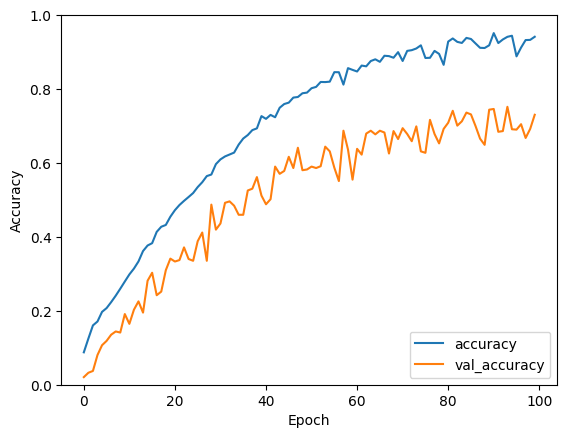

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(model, epochs=100, load_from_file=False, net_name="lrg_cnn_fine", summary=False,show_train_graph=True, data_aug=True, verbose=True)

## Train second with learning rate 0.0001

Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9750 - loss: 0.4098 - val_accuracy: 0.8059 - val_loss: 1.1430
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9906 - loss: 0.2860 - val_accuracy: 0.8078 - val_loss: 1.0433
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9929 - loss: 0.2463 - val_accuracy: 0.8029 - val_loss: 1.0021
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9921 - loss: 0.2310 - val_accuracy: 0.8127 - val_loss: 0.9763
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9957 - loss: 0.2143 - val_accuracy: 0.7931 - val_loss: 0.9970
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9939 - loss: 0.2138 - val_accuracy: 0.8088 - val_loss: 0.9555
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9952 - loss: 0.2052 - val_accuracy: 0.8127 - val_loss: 0.9305
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9955 - loss: 0.1929 - val_acc

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.80
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.80


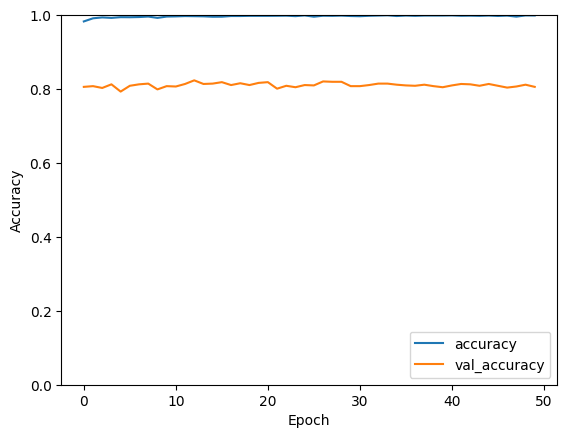

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(model, epochs=50, load_from_file=False, net_name="lrg_cnn_fine", summary=False,show_train_graph=True, data_aug=True, verbose=True)

## Train third with learning rate 0.00001

In [2]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(model, epochs=100, load_from_file=True, net_name="lrg_cnn_fine", summary=False,show_train_graph=True, data_aug=True, verbose=True)

NameError: name 'net' is not defined